In [1]:
## System
import sys
import os
from collections import defaultdict

## Pandas
import pandas as pd
import numpy as np

## Plotting 
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

## Fig utils 
from fig_utils import (get_decile_score, 
                       deciles, 
                       OR_color,
                       AR_color,
                       AD_color,
                       HI_color,
                       NonEss_color)


In /Users/michaelcormier/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/michaelcormier/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/michaelcormier/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
## genic ConSplice file path
genic_consplice_file = "../data/ConSplice.gene.scores.autosome.txt"

In [3]:
## score columns
consplice_col = "weighted_sc_percentile"

In [4]:
## Read in the genic ConSplice scores into pandas data frame
ConSplice_df = pd.read_csv(genic_consplice_file, sep = "\t", index_col = False)

In [5]:
## Load gene sets

hi_genes = "../data/HI.genes.tsv"
with open(hi_genes) as hg:
    haploinsufficient_genes = [x.strip() for x in hg]

autosomaldominant_genes = "../data/AD.genes.tsv"
with open(autosomaldominant_genes) as ad:
    ad_genes = [x.strip() for x in ad]
    
autosomalrecessive_genes = "../data/AR.genes.tsv"
with open(autosomalrecessive_genes) as ar:
    ar_genes = [x.strip() for x in ar]
    
olfactoryreceptor_genes = "../data/OR.genes.tsv"
with open(olfactoryreceptor_genes) as org:
    or_genes = [x.strip() for x in org]
    

## Load CRISPR gene sets
crispr_non_essentail_genes = "../data/CRISPR.Nonessential.genes.tsv"
with open(crispr_non_essentail_genes) as cneg:
    crispr_non_essentail = [x.strip() for x in cneg]
    
crispr_essentail_genes = "../data/CRISPR.Essential.genes.tsv"
with open(crispr_essentail_genes) as ceg:
    crispr_essentail = [x.strip() for x in ceg]

In [6]:
## Create new df with gene info 

new_df_list = []

new_df_list.extend([[gene,"Haploinsufficient"] for gene in haploinsufficient_genes])
new_df_list.extend([[gene,"Autosomal Dominant"] for gene in ad_genes])
new_df_list.extend([[gene,"Autosomal Recessive"] for gene in ar_genes])
new_df_list.extend([[gene, "Olfactory Genes"] for gene in or_genes])
new_df_list.extend([[gene,"CRISPR Non-Essential"] for gene in crispr_non_essentail])
new_df_list.extend([[gene,"CRISPR Essential"] for gene in crispr_essentail])

gene_list_df = pd.DataFrame(new_df_list, columns = ["gene","gene_list"])

del new_df_list

In [7]:
## Get the LOEUF scores by gene symbol
with open("../data/gene_to_LOEUF.txt") as loeuf_fh:
    by_gene_loeuf = {line.strip().split("\t")[0]:line.strip().split("\t")[2] for line in loeuf_fh if line.strip().split("\t")[1] != "NA"}

In [8]:
## Get the pLI scores by gene symbol
with open("../data/gene_to_pLI.txt") as pli_fh:
    by_gene_pli = {line.strip().split("\t")[0]:line.strip().split("\t")[1] for line in pli_fh if line.strip().split("\t")[1] != "NA"}

In [9]:
## Add ConSplice scores to gene df
o_e_gene_set = set(ConSplice_df.gene_symbol)
gene_list_df["ConSplice"] = gene_list_df.gene.apply(lambda x: ConSplice_df.loc[ConSplice_df.gene_symbol == x][consplice_col].values[0] if x in o_e_gene_set else "Missing" )

## Add pLI scores to gene df
gene_list_df["loeuf_decile"] = gene_list_df.gene.apply(lambda x: float(by_gene_loeuf[x]) if x in by_gene_loeuf else "Missing" )

## Add LOEUF scores to gene df
gene_list_df["pLI"] = gene_list_df.gene.apply(lambda x: float(by_gene_pli[x]) if x in by_gene_pli else "Missing" )


In [10]:
## Map loeuf deciles to pLI deciles
### LOEUF Deciles need to be reversed to align with pLI deciles

loeuf_to_pli_decile = {0.0: "0.9-1.0",
                       1.0: "0.8-0.9",
                       2.0: "0.7-0.8",
                       3.0: "0.6-0.7",
                       4.0: "0.5-0.6",
                       5.0: "0.4-0.5",
                       6.0: "0.3-0.4",
                       7.0: "0.2-0.3",
                       8.0: "0.1-0.2",
                       9.0: "0.0-0.1",}

In [11]:
## Bin scores and normalize counts

### Scores -> decile bins
gene_list_df["constraint_decile"] = gene_list_df.ConSplice.apply(get_decile_score)
gene_list_df["pLI_decile"] = gene_list_df.pLI.apply(get_decile_score)
gene_list_df["loeuf_deciles_rev"] = gene_list_df.loeuf_decile.map(loeuf_to_pli_decile)

normalized_consplice_df = gene_list_df.loc[gene_list_df.constraint_decile != "None"].groupby("gene_list")["constraint_decile"].value_counts(normalize=True).reset_index(name='splicing constraint').rename(columns={"constraint_decile":"decile"})
normalized_pli_df = gene_list_df.loc[gene_list_df.constraint_decile != "None"].groupby("gene_list")["pLI_decile"].value_counts(normalize=True).reset_index(name='pLI').rename(columns={"pLI_decile":"decile"})
normalized_loeuf_df = gene_list_df.loc[gene_list_df.constraint_decile != "None"].groupby("gene_list")["loeuf_deciles_rev"].value_counts(normalize=True).reset_index(name='LOEUF (Reversed)').rename(columns={"loeuf_deciles_rev":"decile"})

## Combine together
normalized_combined_df = pd.merge(pd.merge(normalized_consplice_df, normalized_pli_df, on = ["gene_list","decile"], how = "outer"), 
                                 normalized_loeuf_df, on = ["gene_list","decile"], how = "outer")

In [12]:
## Convert wide to long for plotting

long_nor_combined_df = pd.melt(normalized_combined_df, id_vars = ["gene_list","decile"], var_name='score_method', value_name='percentage')

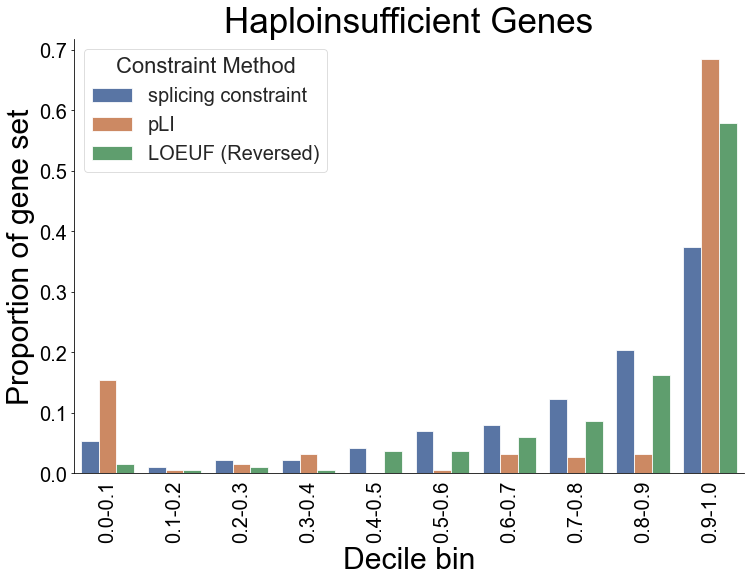

In [13]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

fig, ax = plt.subplots(figsize = (12,8))
sns.set(font='Arial', style = "white")
sns.set_context("paper", font_scale = 2)
sns.despine()


bplot = sns.barplot(data = long_nor_combined_df.loc[long_nor_combined_df.gene_list == "Haploinsufficient"],
                    x = "decile",
                    y = "percentage",
                    hue = "score_method",
                    order = deciles)

ax.set_title("Haploinsufficient Genes", fontsize = 35)
ax.set_ylabel("Proportion of gene set", fontsize = 30)
ax.set_xlabel("Decile bin", fontsize = 30)

ax.tick_params(axis="x", which = "both", bottom = False, top = False, labelsize=20, rotation = 90, )
ax.tick_params(axis="y", labelsize=20)  

ax.legend(title = "Constraint Method", fontsize = 20, title_fontsize = 22, loc = "best")

plt.savefig('../figures/suppl_figure4_A.svg')

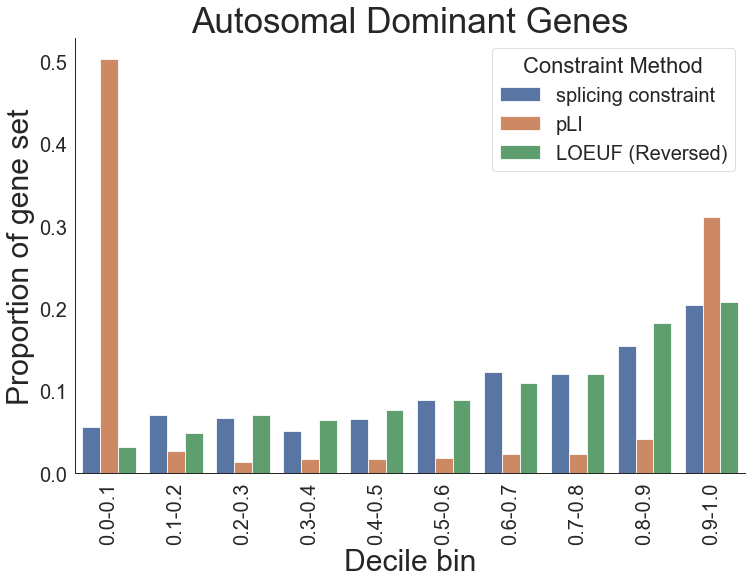

In [14]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

fig, ax = plt.subplots(figsize = (12,8))
sns.set(font='Arial', style = "white")
sns.set_context("paper", font_scale = 2)
sns.despine()


bplot = sns.barplot(data = long_nor_combined_df.loc[long_nor_combined_df.gene_list == "Autosomal Dominant"],
                    x = "decile",
                    y = "percentage",
                    hue = "score_method",
                    order = deciles)

ax.set_title("Autosomal Dominant Genes", fontsize = 35)
ax.set_ylabel("Proportion of gene set", fontsize = 30)
ax.set_xlabel("Decile bin", fontsize = 30)

ax.tick_params(axis="x", which = "both", bottom = False, top = False, labelsize=20, rotation = 90, )
ax.tick_params(axis="y", labelsize=20)  

ax.legend(title = "Constraint Method", fontsize = 20, title_fontsize = 22, loc = "best")

plt.savefig('../figures/suppl_figure4_B.svg')

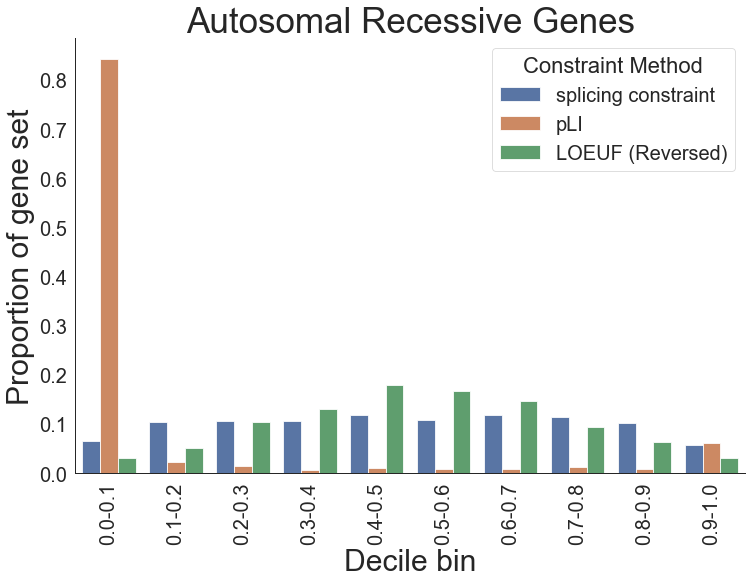

In [15]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

fig, ax = plt.subplots(figsize = (12,8))
sns.set(font='Arial', style = "white")
sns.set_context("paper", font_scale = 2)
sns.despine()


bplot = sns.barplot(data = long_nor_combined_df.loc[long_nor_combined_df.gene_list == "Autosomal Recessive"],
                    x = "decile",
                    y = "percentage",
                    hue = "score_method",
                    order = deciles)

ax.set_title("Autosomal Recessive Genes", fontsize = 35)
ax.set_ylabel("Proportion of gene set", fontsize = 30)
ax.set_xlabel("Decile bin", fontsize = 30)

ax.tick_params(axis="x", which = "both", bottom = False, top = False, labelsize=20, rotation = 90, )
ax.tick_params(axis="y", labelsize=20)  

ax.legend(title = "Constraint Method", fontsize = 20, title_fontsize = 22, loc = "best")

plt.savefig('../figures/suppl_figure4_C.svg')

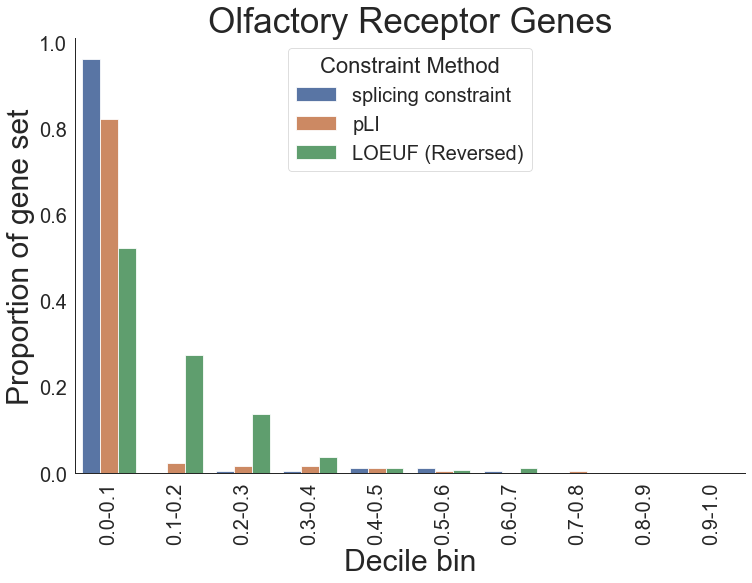

In [16]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

fig, ax = plt.subplots(figsize = (12,8))
sns.set(font='Arial', style = "white")
sns.set_context("paper", font_scale = 2)
sns.despine()


bplot = sns.barplot(data = long_nor_combined_df.loc[long_nor_combined_df.gene_list == "Olfactory Genes"],
                    x = "decile",
                    y = "percentage",
                    hue = "score_method",
                    order = deciles)

ax.set_title("Olfactory Receptor Genes", fontsize = 35)
ax.set_ylabel("Proportion of gene set", fontsize = 30)
ax.set_xlabel("Decile bin", fontsize = 30)

ax.tick_params(axis="x", which = "both", bottom = False, top = False, labelsize=20, rotation = 90, )
ax.tick_params(axis="y", labelsize=20)  

ax.legend(title = "Constraint Method", fontsize = 20, title_fontsize = 22, loc = "best")

plt.savefig('../figures/suppl_figure4_D.svg')

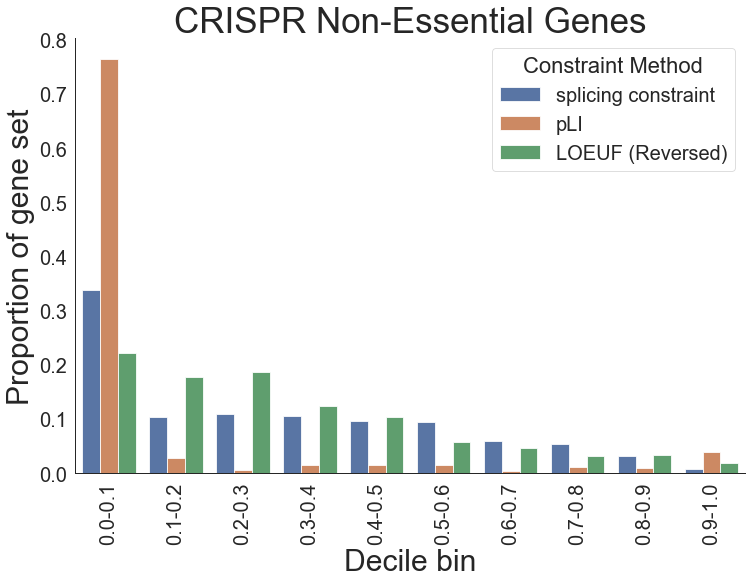

In [17]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

fig, ax = plt.subplots(figsize = (12,8))
sns.set(font='Arial', style = "white")
sns.set_context("paper", font_scale = 2)
sns.despine()


bplot = sns.barplot(data = long_nor_combined_df.loc[long_nor_combined_df.gene_list == "CRISPR Non-Essential"],
                    x = "decile",
                    y = "percentage",
                    hue = "score_method",
                    order = deciles)

ax.set_title("CRISPR Non-Essential Genes", fontsize = 35)
ax.set_ylabel("Proportion of gene set", fontsize = 30)
ax.set_xlabel("Decile bin", fontsize = 30)

ax.tick_params(axis="x", which = "both", bottom = False, top = False, labelsize=20, rotation = 90, )
ax.tick_params(axis="y", labelsize=20)  

ax.legend(title = "Constraint Method", fontsize = 20, title_fontsize = 22, loc = "best")

plt.savefig('../figures/suppl_figure4_E.svg')

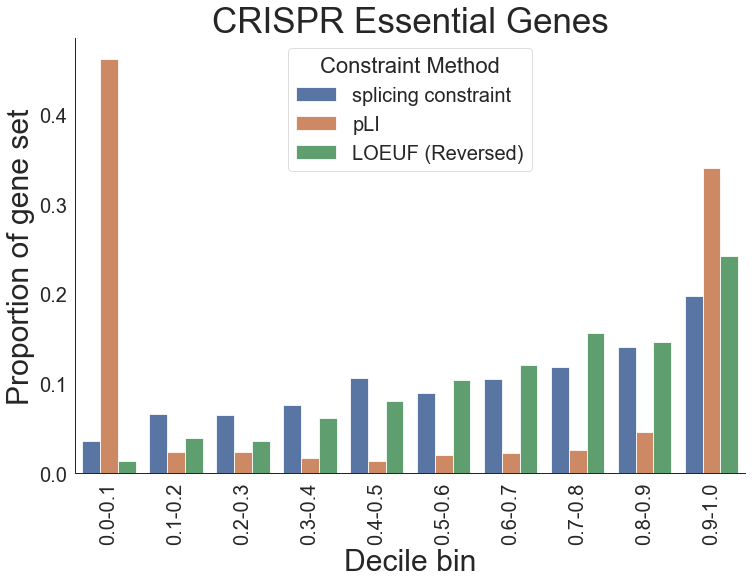

In [18]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

fig, ax = plt.subplots(figsize = (12,8))
sns.set(font='Arial', style = "white")
sns.set_context("paper", font_scale = 2)
sns.despine()


bplot = sns.barplot(data = long_nor_combined_df.loc[long_nor_combined_df.gene_list == "CRISPR Essential"],
                    x = "decile",
                    y = "percentage",
                    hue = "score_method",
                    order = deciles)

ax.set_title("CRISPR Essential Genes", fontsize = 35)
ax.set_ylabel("Proportion of gene set", fontsize = 30)
ax.set_xlabel("Decile bin", fontsize = 30)

ax.tick_params(axis="x", which = "both", bottom = False, top = False, labelsize=20, rotation = 90, )
ax.tick_params(axis="y", labelsize=20)  

ax.legend(title = "Constraint Method", fontsize = 20, title_fontsize = 22, loc = "best")

plt.savefig('../figures/suppl_figure4_F.svg')